In [17]:
import os
# os.environ['CUDA_VISIBLE_DEVICES']='0'

import cv2
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image

import tensorflow as tf
from model_deeplab import *

### requirements

In [18]:
# !brew install ffmpeg
# !pip3 install ffmpeg ffprobe scikit-video pytube

In [325]:
from pytube import YouTube
# url = "https://www.youtube.com/watch?v=G9ZM43ZpoCE" # Roger
# url = "https://www.youtube.com/watch?v=qAJLHBB5Js0" # Djokovic
# url = "https://www.youtube.com/watch?v=JA7G7AV-LT8" # Jordan
url = "https://www.youtube.com/watch?v=-ZY4ujdm0ag"
yt = YouTube(url)
yt.streams.first().download('~/magic-effect/')

'~/magic-effect/iDance Mikey  SOLO Dance Competition Winner  World of Dance Las Vegas 2015  WODVEGAS15.mp4'

In [20]:
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = '~/magic-effect/model/'#tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

#@title Run on sample images {display-mode: "form"}

SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = ''  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


In [21]:
def run_visualization(f, verbose=False):
    """Inferences DeepLab model and visualizes result."""
    try:
        if isinstance(f, str):
            original_im = Image.open(f)
        elif isinstance(f, np.ndarray):
            original_im = Image.fromarray(f)
    except:
        print("Unexpected error: invalid input")
        raise
    
#     print('running deeplab on image %s...' % f)
    resized_im, seg_map = MODEL.run(original_im)
    if verbose:
        vis_segmentation(resized_im, seg_map)
    return resized_im, seg_map

def find_cntr(cv2_img, n_max=5, th=1000):
    '''input: cv2_img = cv2.imread(img_path)'''
    '''output: mask '''
    b,g,r = cv2.split(cv2_img)  
    img = cv2.merge([r,g,b])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _,th2 = cv2.threshold(gray,10,1,cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(th2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    areas = [-cv2.contourArea(contour) for contour in contours]
    num = max(n_max, np.sum(np.array(areas) < (-1)*th))
    return [contours[top] for top in np.argsort(areas)[:num]]

def get_stroke(image, color, width=10):
    element = cv2.getStructuringElement(cv2.MORPH_RECT,(width,width))
#     element_erode = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    dilate = cv2.dilate(image, element)
#     erode = cv2.erode(image, element_erode)
    result = cv2.absdiff(dilate, image)#erode)
    retval, result = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY)
    colored_result = np.stack((result/255.0 * color[0],
                               result/255.0 * color[1],
                               result/255.0 * color[2]), axis=2).astype(np.uint8)
    return colored_result

def run_stroke_effect(f):
    rgb, mask = run_visualization(f)
    rgb = np.array(rgb)
    fore  = np.array(mask == 15, np.uint8) * 255
    
    # find contours on person semantic mask
    k = find_cntr(np.stack((fore, fore, fore),axis=2).astype(np.uint8))
    
    # select at most five contours
    num = min(len(k), 5)
    colors = [(252,141,98),(102,194,165), (141,160,203),(231,138,195),(166,216,84)]
    
    # combine all contours with different colors
    s = np.zeros(rgb.shape, np.uint8)
    for i in range(num):
        canvas = np.zeros(rgb.shape[0:2], np.uint8)
        fore = cv2.drawContours(canvas, k, i, (255,255,255),-1)
        s += cv2.medianBlur(get_stroke(fore, color=colors[i], width=10), 1)
        
    # combine with original images
    rgb_new = rgb*(1-(s>0)) + s
    return rgb, rgb_new

In [120]:
def rotate_vector(vector, degree):
    """
    @vector: two dimension input like [1, 0], (1,0), or np.array([1, 0])
    @degree: rotation angle
    
    [ cos0 -sin0
      sin0  cos0 ]
    
    return roration vector
    """
    cos = np.cos(np.pi/180 * degree)
    sin = np.sin(np.pi/180 * degree)
    
    return [vector[0] * cos - vector[1] * sin, vector[0] * sin + vector[1] * cos]

def add_line(cntr_points, length, space, angle):
    """
    add patterns between any two consecutive points (a, b)
    
    Arguments
    @points: points of interest
    @length: the length of the line
    @space:  the space between the contour and perpendicular lines
    @angle:  the rotation angle of the vector, b - a
    
    Return
    - np.array(p1): the start point of lines
    - np.array(p2): the end point of lines
    """
    p1 = list()
    p2 = list()
    for i in range(len(cntr_points)-1):
        a = cntr_points[i]
        b = cntr_points[i+1]
        midx, midy = (a+b)/2
        
        vx, vy = b - a
        
        if vx == 0 and vy ==0:
            continue
        else:
            mag = np.sqrt( vx**2 + vy**2)

    #         print(vx, vy)

            vx = vx/mag
            vy = vy/mag

            wx, wy = rotate_vector(vector=[vx, vy], degree=angle)

    #         print(vx, vy)
            cx = int(midx + space*wx)
            cy = int(midy + space*wy)

            dx = int(cx + wx * length)
            dy = int(cy + wy * length)

            p1.append([cx, cy])
            p2.append([dx, dy])
    return np.array(p1), np.array(p2)

In [250]:
def run_pattern_effect(f, pattern, sample_rate, length, space, angle):
    image, mask = run_visualization(f)

    image = np.array(image)
    fore  = np.array(mask == 15, np.uint8) * 255 # 15 means person

    # find contours on person semantic mask
    k = find_cntr(np.stack((fore, fore, fore),axis=2).astype(np.uint8))
    
    pattern_radius_x, pattern_radius_y = pattern.shape[0]//2, pattern.shape[1]//2
    
    # select at most five contours
    num = min(len(k), 5)
    colors = np.array([(102,194,165),(252,141,98),(141,160,203),(231,138,195),(166,216,84)], dtype=np.uint8)

    # combine all contours with different colors
    s = np.zeros(image.shape, np.uint8)
    for i in range(len(k)):
        l = np.zeros(image.shape, np.uint8)
        points = np.mean(k[i], axis=1)
        if len(points) >= 2*sample_rate:
            pattern_points = points[np.random.choice(range(sample_rate), 1)[0]::sample_rate]
            new_points1, new_points2 = add_line(cntr_points=pattern_points, length=length, space=space, angle=angle)

            new_points2 = new_points2[[True]+[True if np.sum((p[0] > 1.4*pattern_radius_x) or (p[1] > 1.4*pattern_radius_y))>0 else False for p in np.abs(np.diff(new_points2, axis=0))]]

            for j in range(len(new_points2)):
                if (new_points2[j][1]+pattern_radius_y < l.shape[0] and new_points2[j][0] + pattern_radius_x < l.shape[1]) and (new_points2[j][1]-pattern_radius_y > 0 and new_points2[j][0] - pattern_radius_x >0):
                    l[new_points2[j][1]-pattern_radius_y:new_points2[j][1]+pattern_radius_y, 
                      new_points2[j][0]-pattern_radius_x:new_points2[j][0]+pattern_radius_x,:] = pattern
            canvas = np.zeros(image.shape[0:2], np.uint8)
            fore = cv2.drawContours(canvas, k, i, (255,255,255),-1)
            l += cv2.medianBlur(get_stroke(fore, color=colors[i], width=10), 1)
            s += l

    image_new = image*(1-(s>0)) + s
    return image, image_new

### Running

In [295]:
import skvideo.io

filename = 'video_Allen-lock.mp4'
cap = skvideo.io.vread(filename)
print(cap.shape)

(1345, 720, 1280, 3)


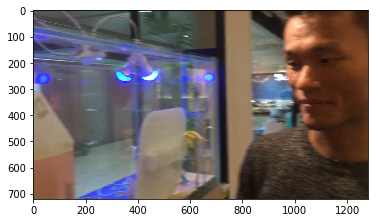

In [313]:
plt.imshow(cap[930]) #670

In [314]:
if filename == 'video_Roger.mp4':
    video = cap[0:500:3]
elif filename == 'video_Kobe.mp4':
    video = cap[935:1040]
elif filename == 'video_SuperMario.mp4':
    video = cap[1430:1650]
elif filename == 'video_Kinjaz.mp4':
    video = cap[2740:3170]
elif filename == 'video_Kinjaz2.mp4':
    video = cap[180:450]
elif filename == 'video_PeopleDance.mp4':
    video = cap[600:900]
elif filename == 'video_Aaron.mp4':
    video = cap[1520:1720]
elif filename == 'video_Allen-lock.mp4':
    video = cap[670:930]
else:
    video = cap

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


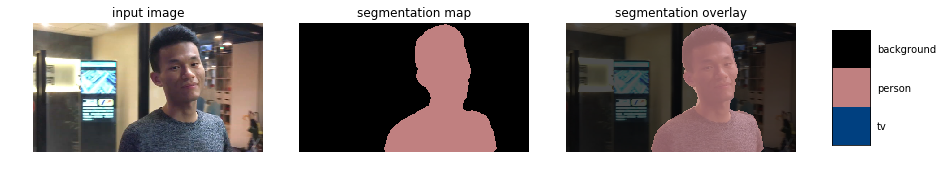

In [315]:
image, mask = run_visualization(video[0], verbose=True)

image = np.array(image)
fore  = np.array(mask == 15, np.uint8) * 255 # 15 means person

# find contours on person semantic mask
k = find_cntr(np.stack((fore, fore, fore),axis=2).astype(np.uint8))

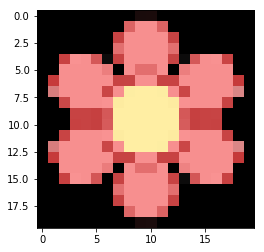

In [316]:
icon = cv2.cvtColor(cv2.imread('flower-icon2.png'), cv2.COLOR_BGR2RGB)
icon[np.mean(icon, axis=2)>= 255] = 0
icon = cv2.resize(icon, (20,20))
plt.imshow(icon)

In [317]:
sample_rate=50
length=10
space=10
angle=90
line_thickness=3
stroke_thickness=10

In [318]:
image, image_new = run_pattern_effect(video[138], 
                                      pattern=icon, 
                                      sample_rate=sample_rate, 
                                      length=length, 
                                      space=space, 
                                      angle=angle)

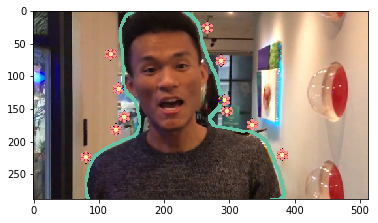

In [319]:
plt.imshow(image_new)

#### Running for videos 

In [320]:
import time
start_time = time.time()
ori_video = list()
new_video = list()
for i in range(video.shape[0]):
    print('{}/{}'.format(i, video.shape[0]), end='\r')
    orif, newf = run_pattern_effect(video[i], pattern=icon, sample_rate=sample_rate, length=length, space=space, angle=angle)
    ori_video.append(orif)
    new_video.append(newf)
newv = np.stack(new_video, axis=0)
oriv = np.stack(ori_video, axis=0)
print('time: {0:.3f}, output shape: {1}'.format(time.time()-start_time, newv.shape))

time: 156.312, output shape: (260, 288, 513, 3)


In [321]:
newv = newv.astype(np.uint8)
oriv = oriv.astype(np.uint8)

In [322]:
skvideo.io.vwrite(fname='pattern-{}'.format(filename), videodata = newv, backend='ffmpeg', verbosity=1)

/usr/local/bin/ffmpeg -y -f rawvideo -pix_fmt rgb24 -s 513x288 -i - /Users/cmchang/magic-effect/pattern-video_Allen-lock.mp4


In [323]:
comp = np.concatenate((oriv, np.zeros(shape=(*oriv.shape[0:2], 10, 3), dtype=np.uint8), newv), axis=2)

In [324]:
skvideo.io.vwrite(fname='pattern-compare-{}'.format(filename), videodata = comp, backend='ffmpeg', verbosity=1)

/usr/local/bin/ffmpeg -y -f rawvideo -pix_fmt rgb24 -s 1036x288 -i - /Users/cmchang/magic-effect/pattern-compare-video_Allen-lock.mp4
